In [75]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
from latentrees import *

In [162]:
runtime = analyses()
#runtime.append_model(L=50, distribution = lambda node: np.clip(round(rng.normal(node, abs(node)**0.25)),-1e10,1e10))
for i in range(1000):
    #runtime.append_model(L=20, distribution = lambda node: np.clip(round(rng.normal(node, 0.01+abs(node))),-1e5,1e5))
    runtime.append_model(L=10)
print(runtime)
runtime.run()
layers = runtime.models[0].layers
L = runtime[0].L
nl = runtime[0].nl

analysis with 1000 models: ['model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model with 10 layers and 3 splits', 'model wit

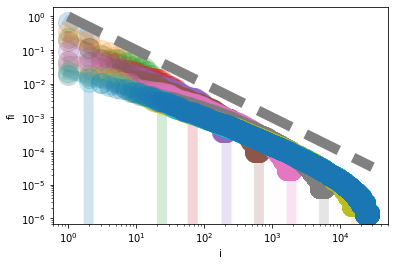

In [124]:
fig = plt.figure()

for l in range(L+1):
    freqs = layers[l].sorted_nodes
    x = np.linspace(1, len(freqs), len(freqs))
    plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, lw=10, alpha=0.2)

plt.plot(x, 1/x, color="gray", lw=10, ls="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("i")
plt.ylabel("fi")
fig.show()

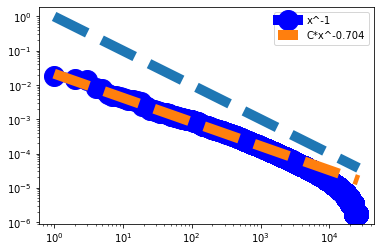

In [127]:
#freqs = np.sort(np.concatenate([l.sorted_nodes for l in layers]).ravel())[::-1]
#
#plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

layer_of_interest = layers[-1]
cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
cnts = np.sort(cnts[cnts>0])[::-1]

x = np.linspace(1, len(cnts), len(cnts))

plt.plot(x, cnts, marker="o", ms=20, c="blue", lw=10, label="x^-1")

plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[10:2000], cnts[10:2000])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")

plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-8,1)
plt.legend()

In [ ]:
freqs = np.sort(np.unique(layers[-1].nodes,return_counts=True)[1])[::-1]
x = np.linspace(1, len(freqs), len(freqs))
plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[5:], (freqs/np.sum(freqs))[5:])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")


plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5,5e-1)
plt.legend()

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i,ax in enumerate(axs):
    loi = layers[i]
    leaves = loi.nodes[:1000]
    avg_leaves = loi.average
    sns.heatmap(list(map(lambda leaf_A: list(map(lambda leaf_B: np.abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else 0,enumerate(leaves))),enumerate(leaves))), ax=ax)

## Histogram of distances

In [20]:
loi = layers[-1]
if len(loi)>5000:
    leaves = np.random.choice(loi.nodes,size=5000,replace=False)
else:
    leaves = loi.nodes
avg_leaves = loi.median
#distances = np.ravel(list(map(lambda leaf_A: list(map(lambda leaf_B: abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else np.nan,enumerate(leaves))),enumerate(leaves))))
distances = np.ravel(list(map(lambda leaf: abs(leaf-avg_leaves),enumerate(leaves))))
distances = distances[~np.isnan(distances)]
distances = distances[distances>0]

data = dict()
data["1"]=distances

In [21]:
#import pickle
#with open("data_distances.pkl","wb") as file:
#    pickle.dump(data, file)
#with open("data_distances.pkl","rb") as file:
#    data = pickle.load(file)

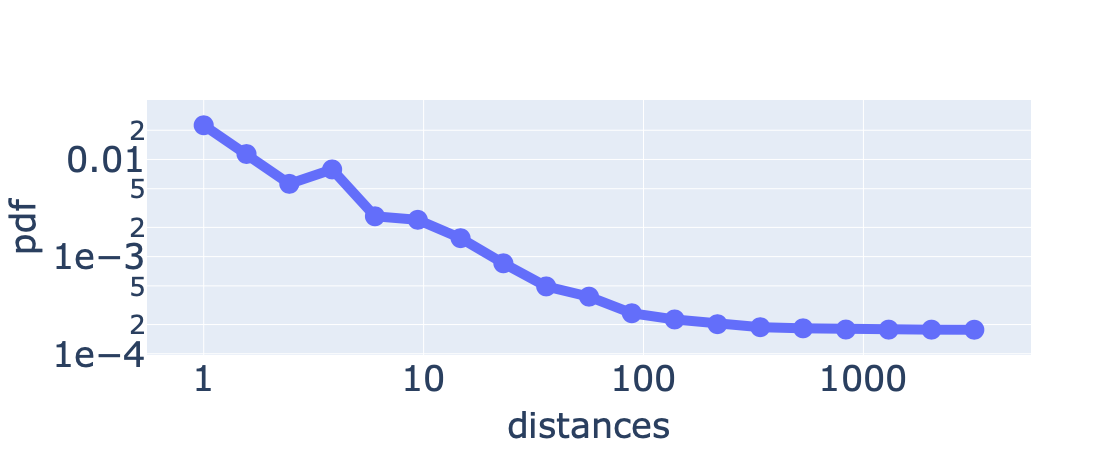

In [22]:
fig = go.Figure()

n_leaves = len(leaves)
for var,distances in data.items():
    bins=np.logspace(np.log10(distances.min()),np.log10(distances.max()), 20)
    #bins=np.linspace(distances.min(),distances.max(),20)
    bins, edges = np.histogram(distances, bins=bins, density=True)
    esges = (edges[1:]+edges[:1])/2
    fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=var))

fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, type="log", nticks= 5),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=5),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

fig.show()
#fig.write_image("images/pdf_distances.pdf")
#fig.write_html("images/pdf_distances.html")

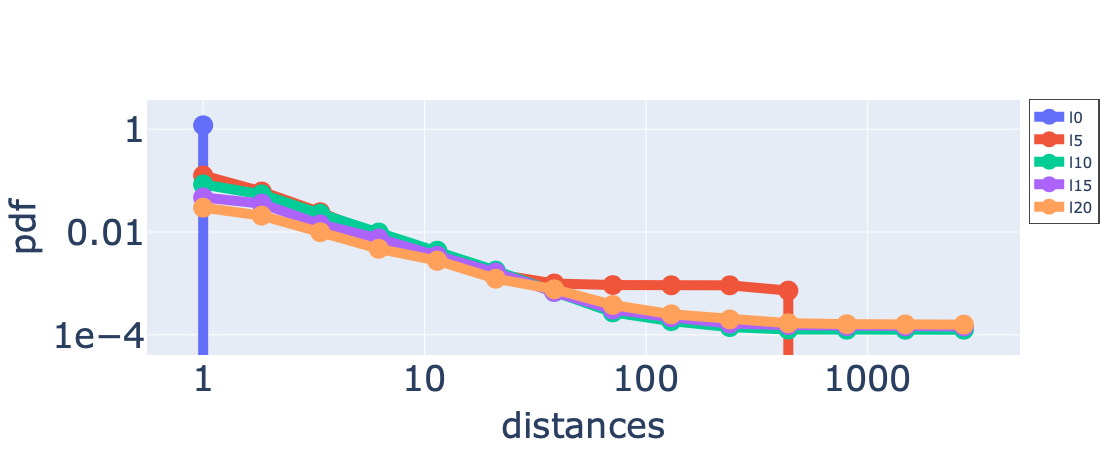

In [23]:
fig = go.Figure()

for loi in layers[::5]:
    if len(loi)>10000:
        leaves = np.random.choice(loi.nodes,size=10000,replace=False)
    else:
        leaves = loi.nodes
    avg_leaves = loi.median
    #distances = np.ravel(list(map(lambda leaf_A: list(map(lambda leaf_B: abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else np.nan,enumerate(leaves))),enumerate(leaves))))
    distances = np.ravel(list(map(lambda leaf: abs(leaf-avg_leaves),enumerate(leaves))))
    distances = distances[~np.isnan(distances)]
    distances = distances[distances>0]
    
    n_leaves = len(leaves)

    bins=np.logspace(np.log10(distances.min()),np.log10(5e3), 15)
    #bins=np.linspace(distances.min(),distances.max(),20)
    bins, edges = np.histogram(distances, bins=bins, density=True)
    esges = (edges[1:]+edges[:1])/2
    fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=loi.__repr__().split(",")[0]))

fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, type="log", nticks= 4),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=4),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

fig.show()
#fig.write_image("images/distance_pdf_layers.pdf")
#fig.write_html("images/distance_pdf_layers.html")

# Hyperparameters

Gaussian scaling vs exponent L=50

In [ ]:
fig = go.Figure()

fig.add_scatter(x=scaling, y=scaling_exp)
fig.add_trace(go.Scatter(x=[0,1],y=[1,1],mode="lines",line = dict(width=5, dash="dash")))

fig.update_traces(marker_size=25, line_width=10)
fig.update_layout(xaxis=dict(title="Scaling", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Exponent",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)))
fig.update_layout(showlegend=False)
fig.show()
fig.write_image("exp_scaling.png")

In [ ]:
fig = go.Figure()

fig.add_scatter(x=variance, y=mean_distance, name="average distance")
#fig.add_scatter(x=variance, y=exponent, name="exponent")

fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Variance", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Average distance",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)),
                 xaxis_type="log")
fig.show()
fig.write_image("exp_scaling.pdf")

In [ ]:
avg = [np.average(np.abs(np.array(l.nodes)[1:]-l.nodes[:-1]))/l.average for l in layers]
#maxs = [np.max(np.abs(np.array(l.nodes)[1:]-l.nodes[:-1]))/l.average for l in layers]

fig = go.Figure()

fig.add_scatter(y=avg, x=list(range(len(avg))), name="average distance", line=dict(width=10, color="gray"))
#fig.add_scatter(y=maxs, x=list(range(len(avg))), name="maximum distance", line=dict(width=10, color="gray"))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Layer", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Distance*",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)))
fig.show()
fig.write_image("distance_layer_negativem2.png")

## gamma

In [15]:
def get_exp(layer)->float:
    try:
        layer_of_interest = layer
        cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
        cnts = np.sort(cnts[cnts>0])[::-1]
        x = np.linspace(1, len(cnts), len(cnts))

        popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[10:1000], cnts[10:1000])
        return popt[1]
    except:
        return np.nan
    
exps = np.nanmean([list(map(get_exp, model.layers)) for model in runtime], axis=0)
exps_errors = np.nanstd([list(map(get_exp, model.layers)) for model in runtime], axis=0)

<ipython-input-15-1e4378a701b5>:13: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning:

Degrees of freedom <= 0 for slice.



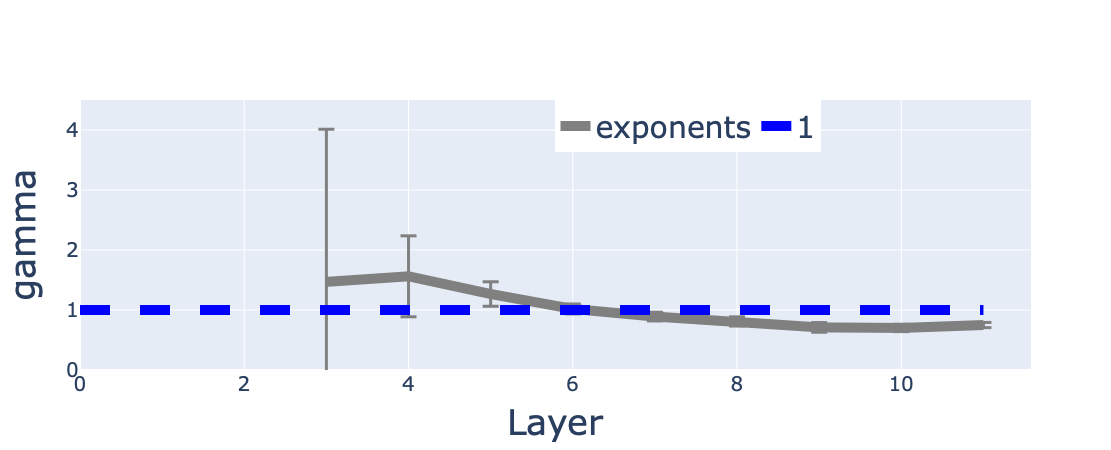

In [109]:
x = np.linspace(1,len(layers),len(layers))

fig = go.Figure()

fig.add_scatter(x = x, y=exps, error_y=dict(type="data", array=exps_errors, visible=True, width=8, thickness=3), name="exponents", mode="lines", marker=dict(size=10), line=dict(width=10, color="gray"))
fig.add_trace(go.Scatter(y=[1,1], x=[0,len(layers)], name="1", mode="lines", line=dict(width=10, color="blue", dash="dash")))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Layer", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="gamma",
                  yaxis=dict(range=(0,4.5),tickfont=dict(size=20), title_font=dict(size=35)),
                 legend=dict(font_size=30, orientation="h", x=0.5, y=1))
fig.show()

## Heaps

In [163]:
h = [len(np.unique(m.layers[-1].nodes)) for m in runtime]
M = np.array([np.sum(m.layers[-1].nodes) for m in runtime])

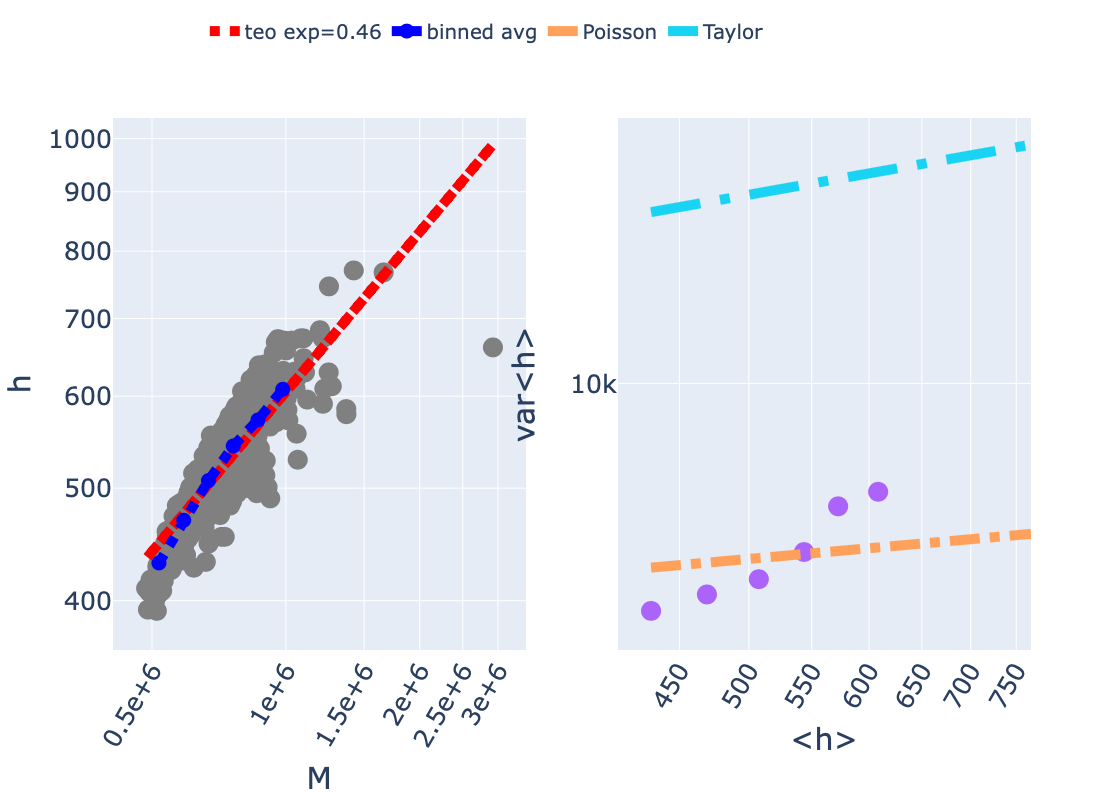

In [178]:
x = np.linspace(min(M), max(M), 10)

fig = make_subplots(cols=2, rows=1)

popt,pcov = curve_fit(lambda x, C, gamma: C*np.power(x,gamma), M, h)

fig.add_scatter(x=M,y=h, mode="markers", marker=dict(size=20, color="gray"), showlegend=False, row=1, col=1)

popt, pcov = curve_fit(lambda x, C, exp: C*np.power(x,exp), M, h)
fig.add_scatter(x=M,y=popt[0]*np.power(M,popt[1]), mode="lines", line=dict(width=10, color="red", dash="dot"), name="teo exp={:.2f}".format(popt[1]), row=1, col=1)


bins = np.logspace(np.log10(M.min()),np.log10(M.max()),15)
means, edges, _ = binned_statistic(M,h, statistic="mean", bins=bins)
var, edges, _ = binned_statistic(M,h, statistic="std", bins=bins)
var = var*var
cnt, edges, _ = binned_statistic(M,h, statistic="count", bins=bins)

mask = cnt > 10

fig.add_scatter(x=(edges[1:]+edges[:-1])[mask]/2, y=means[mask], mode="markers+lines", line=dict(width=10, color="blue", dash="dot"), marker=dict(size=15), name="binned avg", row=1, col=1)


fig.update_xaxes(type="log", 
                 title="M",
                 title_font_size=30, 
                 tickfont_size=25, 
                 exponentformat="e", 
                 showexponent="all", 
                 tickangle=300,
                 row=1, col=1)
                 
fig.update_yaxes(type="log",
                 title="h",
                 title_font_size=30, 
                 tickfont_size=25, 
                 nticks=5,
                 row=1, col=1)

x = np.linspace(min(means), max(means), 10)
fig.add_trace(go.Scatter(x=means[mask],y=var[mask], mode="markers", marker = dict(size=20),showlegend=False), row=1, col=2)
fig.add_traces([
    go.Scatter(x=x, y=x, name="Poisson", mode="lines", line=dict(width=10, dash="dashdot")),
    go.Scatter(x=x, y=x**2, name="Taylor", mode="lines", line=dict(width=10, dash="longdashdot"))
],rows=1, cols=2)

fig.update_xaxes(type="log", 
                 title="<h>",
                 title_font_size=30, 
                 tickfont_size=25, 
                 exponentformat="e", 
                 showexponent="all", 
                 tickangle=300,
                 row=1, col=2)
                 
fig.update_yaxes(type="log",
                 title="var<h>",
                 title_font_size=30, 
                 tickfont_size=25, 
                 nticks=2,
                 row=1, col=2)

fig.update_layout(legend=dict(font_size=20, orientation="h", x=0.1,y=1.2),width=1500, height=800)
fig.show()
fig.write_image("images/heaps.pdf")
fig.write_html("images/heaps.html")

In [24]:
import gc
gc.collect()

5491